In [98]:
import pandas as pd

In [99]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

## Before Creating Cleaned Train.csv

In [51]:
train = pd.read_csv('train.csv')

In [64]:
train.iloc[:,1:].sample(10)

,label,tweet
26756,0,literally geeking so hard over this @user sche...
5710,0,"thank you, pinee! #yehey #goodnews"
14831,0,beautiful wedding in temecula. #photobooth #dj...
15061,1,wew i only know they are diff couples when i l...
3706,0,life is better with a tan ðð»ð #nofile...
26409,0,"now playing : rick wakeman - "" the lone sail..."
28796,1,finally!!! action!!! @user @user #catdjt #ther...
25976,0,so excited to be setting up my own business ve...
25973,0,thoughts and prayers to her familie and friend...
25398,0,@user je relate soo badly! msaken they just ha...


In [58]:
len(train)

31962

In [5]:
X = train['tweet']
y = train['label']

In [9]:
len(corpus)

31962

In [8]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(X)):
    print(i,end = '\r')
    review = re.sub('[^a-zA-Z]', ' ', X[i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [21]:
cleaned_text = pd.DataFrame(corpus)
final = cleaned_text.join(y)
final.head()

,0,label
0,user father dysfunct selfish drag kid dysfunct...,0
1,user user thank lyft credit use caus offer whe...,0
2,bihday majesti,0
3,model love u take u time ur,0
4,factsguid societi motiv,0


In [23]:
final.to_csv('Cleaned_train_data.csv',index = False)

In [24]:
corp_len = 0
for i in corpus:
    corp_len+=len(i)
corp_len

1613759

In [25]:
corp_len/len(corpus)

50.48992553657468

## After Creating Cleaned train data file

In [100]:
data = pd.read_csv('Cleaned_train_data.csv')

In [101]:
len(data)

31962

In [102]:
data.isna().sum()

0        13
label     0
dtype: int64

In [103]:
data = data.dropna()

In [104]:
len(data)

31949

In [105]:
y = data['label']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [106]:
X = data['0']
X = X.values

In [107]:
corpus = []
for i in range(len(X)):
    review = re.sub('[^a-zA-Z]', ' ', X[i])
    review = review.lower()
    corpus.append(review)
    print(i,end = '\r')

# Test Models

In [108]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
cv = CountVectorizer(max_features = 50)
tfidf = TfidfVectorizer(max_features = 50)
X_cv = cv.fit_transform(corpus).toarray()
X_tfidf = tfidf.fit_transform(corpus).toarray()
X_cv.shape, X_tfidf.shape

((31949, 50), (31949, 50))

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def assembled(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 0)
    model = MultinomialNB().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    confusion_m = confusion_matrix(y_test,y_pred)
    print(confusion_matrix(y_test,y_pred))
    precision = round(confusion_m[0][0]/sum(confusion_m[0]),3)
    print('Precision: ', precision)
    recall = round(confusion_m[0][0]/(confusion_m[0][0]+confusion_m[1][0]),3)
    print('Recall: ', recall)
    accuracy = round(accuracy_score(y_test,y_pred),3)
    print('Accuracy: ', accuracy)
    
    return (precision,recall,accuracy)

X = [X_cv,X_tfidf]
title = ['Count Vectorizer','TF-IDF']
Y = []

In [110]:
for i in range(len(X)):
    print(title[i])
    temp = assembled(X[i],y)
    Y.append(temp)
    print('\n\n')

Count Vectorizer
[[7284  146]
 [ 534   24]]
Precision:  0.98
Recall:  0.932
Accuracy:  0.915



TF-IDF
[[7430    0]
 [ 558    0]]
Precision:  1.0
Recall:  0.93
Accuracy:  0.93





## Model Creation

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import numpy as np
from sklearn.model_selection import train_test_split


In [8]:
'''gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,)'''

"gpus = tf.config.experimental.list_physical_devices('GPU')\nfor gpu in gpus:\n    tf.config.experimental.set_memory_growth(gpu,)"

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
voc_size = 50000

In [24]:
onehot_repr=[one_hot(word,voc_size)for word in corpus]

In [25]:
sent_length=30
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[    0     0     0 ... 26956 46528 48158]
 [    0     0     0 ... 42906  3972 24917]
 [    0     0     0 ...     0 15052 15325]
 ...
 [    0     0     0 ... 37681 43048 12703]
 [    0     0     0 ... 15106 33110 13994]
 [    0     0     0 ... 36371 28555 22932]]


In [76]:
## Creating model
embedding_vector_features=64
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.7))
model.add(LSTM(50,return_sequences = True))
model.add(Dropout(0.7))
model.add(LSTM(128))
model.add(Dropout(0.7))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [77]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 64)            3200000   
                                                                 
 dropout_15 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_10 (LSTM)              (None, 30, 50)            23000     
                                                                 
 dropout_16 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               91648     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [78]:
len(embedded_docs),y.shape

(31949, (31949,))

In [79]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [80]:
X_final.shape,y_final.shape

((31949, 30), (31949,))

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, stratify = y_final, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, test_size=0.5, random_state=42)

In [82]:
model_history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=8,batch_size=1000)

Epoch 1/8
24/24 [==============================] - 5s 84ms/step - loss: 0.3917 - accuracy: 0.9070 - val_loss: 0.2596 - val_accuracy: 0.9299
Epoch 2/8
24/24 [==============================] - 1s 36ms/step - loss: 0.2617 - accuracy: 0.9299 - val_loss: 0.2492 - val_accuracy: 0.9299
Epoch 3/8
24/24 [==============================] - 1s 34ms/step - loss: 0.2499 - accuracy: 0.9299 - val_loss: 0.2272 - val_accuracy: 0.9299
Epoch 4/8
24/24 [==============================] - 1s 34ms/step - loss: 0.1864 - accuracy: 0.9367 - val_loss: 0.1580 - val_accuracy: 0.9419
Epoch 5/8
24/24 [==============================] - 1s 35ms/step - loss: 0.1210 - accuracy: 0.9587 - val_loss: 0.1339 - val_accuracy: 0.9554
Epoch 6/8
24/24 [==============================] - 1s 35ms/step - loss: 0.0956 - accuracy: 0.9664 - val_loss: 0.1293 - val_accuracy: 0.9574
Epoch 7/8
24/24 [==============================] - 1s 34ms/step - loss: 0.0802 - accuracy: 0.9727 - val_loss: 0.1333 - val_accuracy: 0.9597
Epoch 8/8
24/24 [===

In [83]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

In [84]:
y_pred=model.predict(X_test)

125/125 [==============================] - 2s 7ms/step


### ROC Curve

In [85]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)

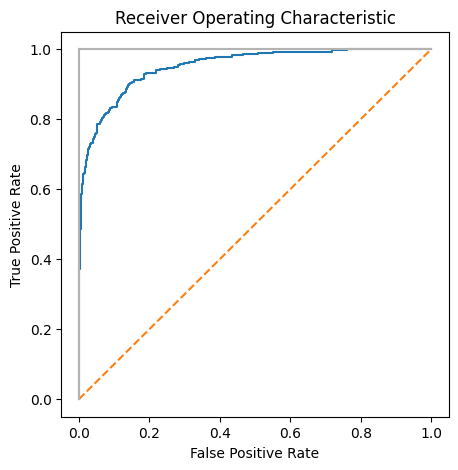

In [86]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [87]:
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

roc_auc_score:  0.9507596738210631


In [88]:
print(model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


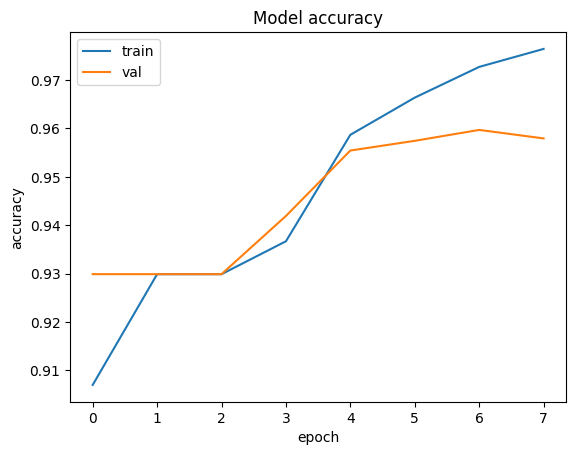

In [89]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

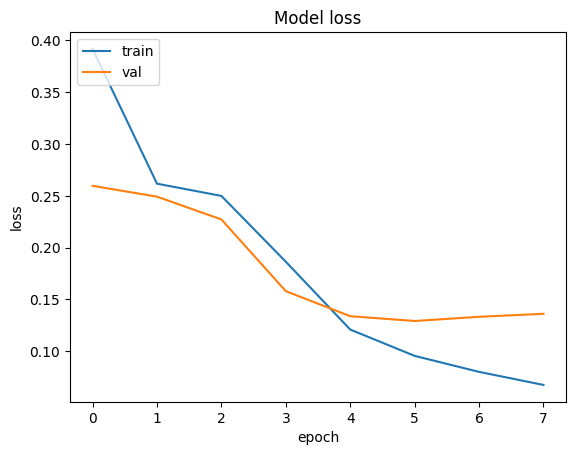

In [90]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

### Predicting Values

In [94]:
y_ = [1 if x>0.4 else 0 for x in y_pred]

In [95]:
cm = confusion_matrix(y_test,y_)
cm

array([[3624,   90],
       [  86,  194]], dtype=int64)

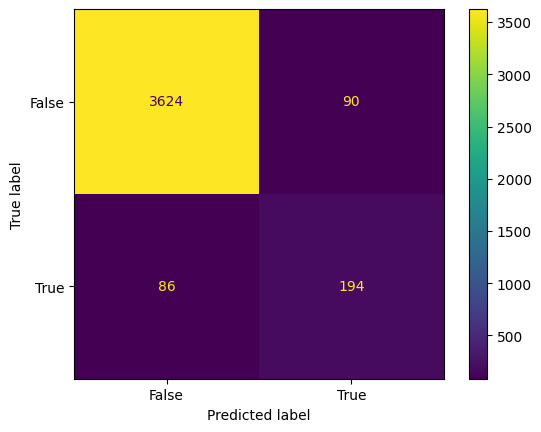

In [96]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

In [114]:
precision = round(cm[0][0]/sum(cm[0]),4)
print('Precision: ', precision)
recall = round(cm[0][0]/(cm[0][0]+cm[1][0]),4)
print('Recall: ', recall)

Precision:  0.9758
Recall:  0.9768


In [97]:
accuracy_score(y_test,y_)

0.9559339008512769

In [143]:
model.save('finalized_model.h5')

In [145]:
import keras

In [146]:
loaded_model = keras.models.load_model('finalized_model.h5')

In [150]:
y_new=loaded_model.predict(X_test)

125/125 [==============================] - 1s 7ms/step


In [151]:
y_ = [1 if x>0.5 else 0 for x in y_new]

In [152]:
cm = confusion_matrix(y_test,y_)
cm

array([[3637,   77],
       [  85,  195]], dtype=int64)

In [153]:
X_test

array([[     0,      0,      0, ..., 167192,  46040, 382868],
       [     0,      0,      0, ..., 410092, 439547,  63193],
       [     0,      0,      0, ..., 223988, 489796, 356651],
       ...,
       [     0,      0,      0, ..., 477944,  66203, 226917],
       [     0,      0,      0, ...,  66679,   8607, 150125],
       [     0,      0,      0, ..., 109994,  69315, 313573]])